In [66]:
import math
import warnings

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.cross_decomposition import PLSRegression
import scipy

%matplotlib inline
sns.set_style('white')

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [2]:
data = pd.read_csv('data.csv')
data.head()

,Rank,Grade,Channel name,Video Uploads,Subscribers,Video views
0,1st,A++,Zee TV,82757,18752951,20869786591
1,2nd,A++,T-Series,12661,61196302,47548839843
2,3rd,A++,Cocomelon - Nursery Rhymes,373,19238251,9793305082
3,4th,A++,SET India,27323,31180559,22675948293
4,5th,A++,WWE,36756,32852346,26273668433


In [3]:
data.describe()

,Video views
count,5.000000e+03
mean,1.071449e+09
std,2.003844e+09
min,7.500000e+01
25%,1.862329e+08
50%,4.820548e+08
75%,1.124368e+09
max,4.754884e+10


In [8]:
print(data.shape)
print(data.dtypes)

(5000, 6)
Rank             object
Grade            object
Channel name     object
Video Uploads    object
Subscribers      object
Video views       int64
dtype: object


In [29]:
# Let's keep only the last 3 columns, which contain numerical data

data = data[['Video Uploads', 'Subscribers', 'Video views']]

In [35]:
data['Subscribers'] = pd.to_numeric(data['Subscribers'], errors='coerce').dropna()
data['Video Uploads'] = pd.to_numeric(data['Video Uploads'], errors='coerce')

In [42]:
data = data.dropna(subset=['Subscribers'])
data['Subscribers'] = data['Subscribers'].astype(int)

data = data.dropna(subset=['Video Uploads'])
data['Video Uploads'] = data['Video Uploads'].astype(int)

In [43]:
print(data.dtypes)

Video Uploads    int64
Subscribers      int64
Video views      int64
dtype: object


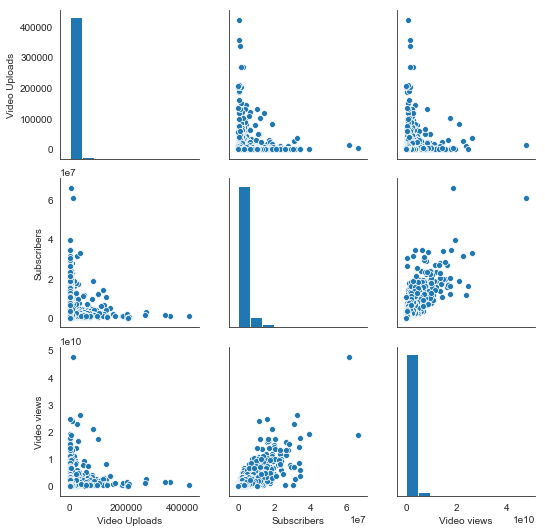

In [44]:
sns.pairplot(data)
plt.show()

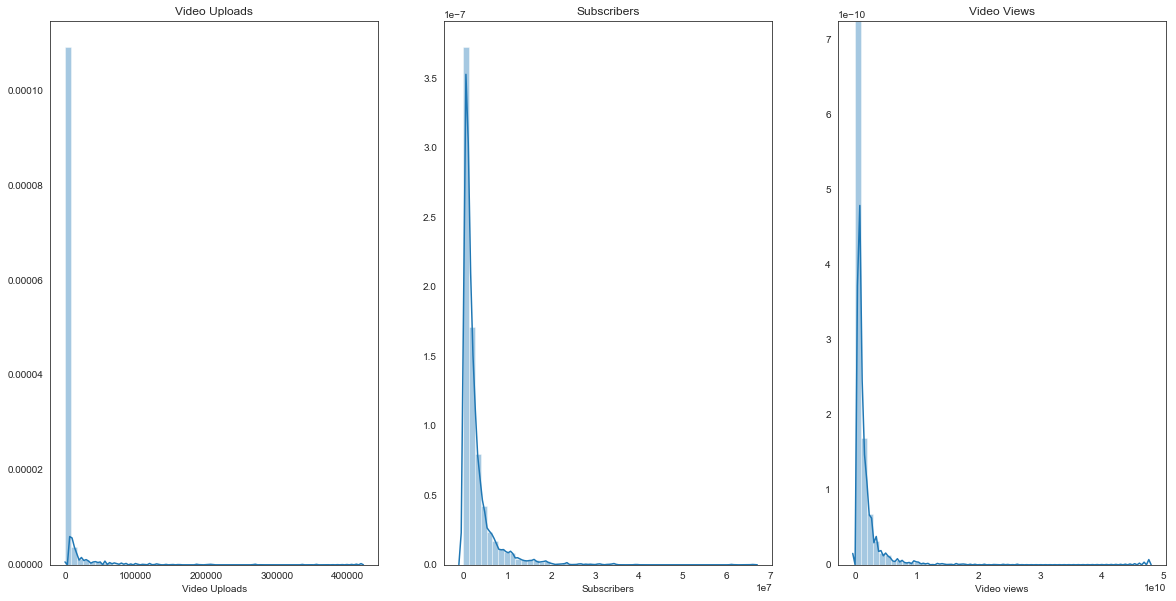

In [63]:
# Let's get to know our data and look for outliers

fig = plt.figure(figsize=(20,10))

plt.subplot(1, 3, 1)
sns.distplot(data['Video Uploads'])
plt.title("Video Uploads")

plt.subplot(1, 3, 2)
sns.distplot(data['Subscribers'])
plt.title("Subscribers")

plt.subplot(1, 3, 3)
sns.distplot(data['Video views'])
plt.title("Video Views")

plt.show()

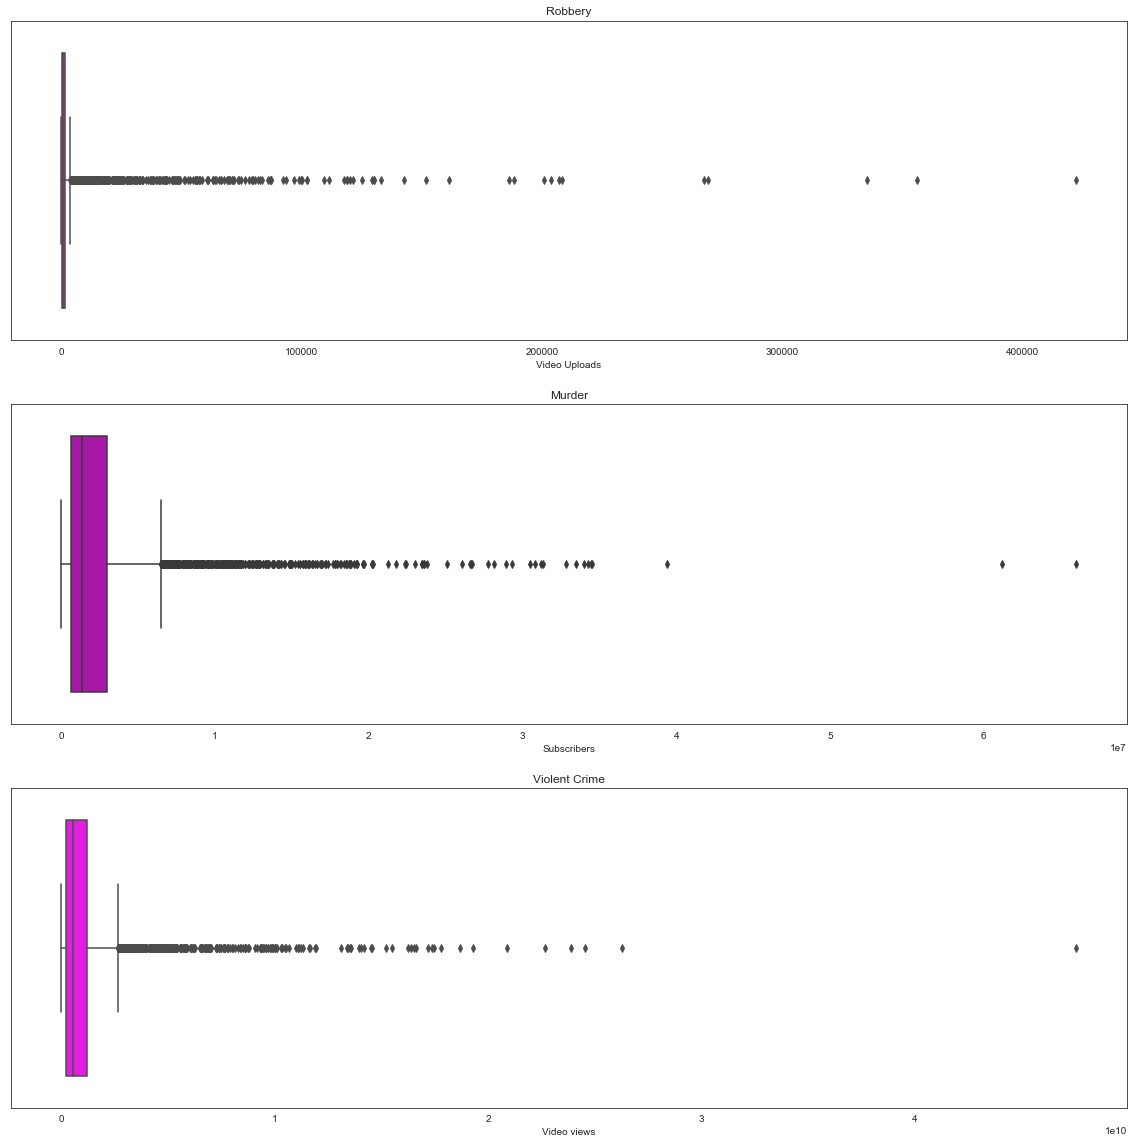

In [64]:
# Find Outliers

uploads = data['Video Uploads']
subscribers = data['Subscribers']
views = data['Video views']


fig, axes = plt.subplots(3, 1, sharex=False, figsize=(20,20))
# Uploads plot
sns.boxplot(uploads, ax=axes[0], color='fuchsia').set_title('Robbery')    
# Subscribers
sns.boxplot(subscribers, ax=axes[1], color='m').set_title('Murder')
# Video Views
sns.boxplot(views, ax=axes[2], color='fuchsia').set_title('Violent Crime')

    

plt.show()

In [72]:
#Windsorize 


# Uploads
data['uploads_w'] = scipy.stats.mstats.winsorize(data['Video Uploads'], limits= 0.003)
# Subscribers
data['subs_w'] = scipy.stats.mstats.winsorize(data['Subscribers'], limits= 0.003)
# Views
data['views_w'] = scipy.stats.mstats.winsorize(data['Video views'], limits= 0.003)


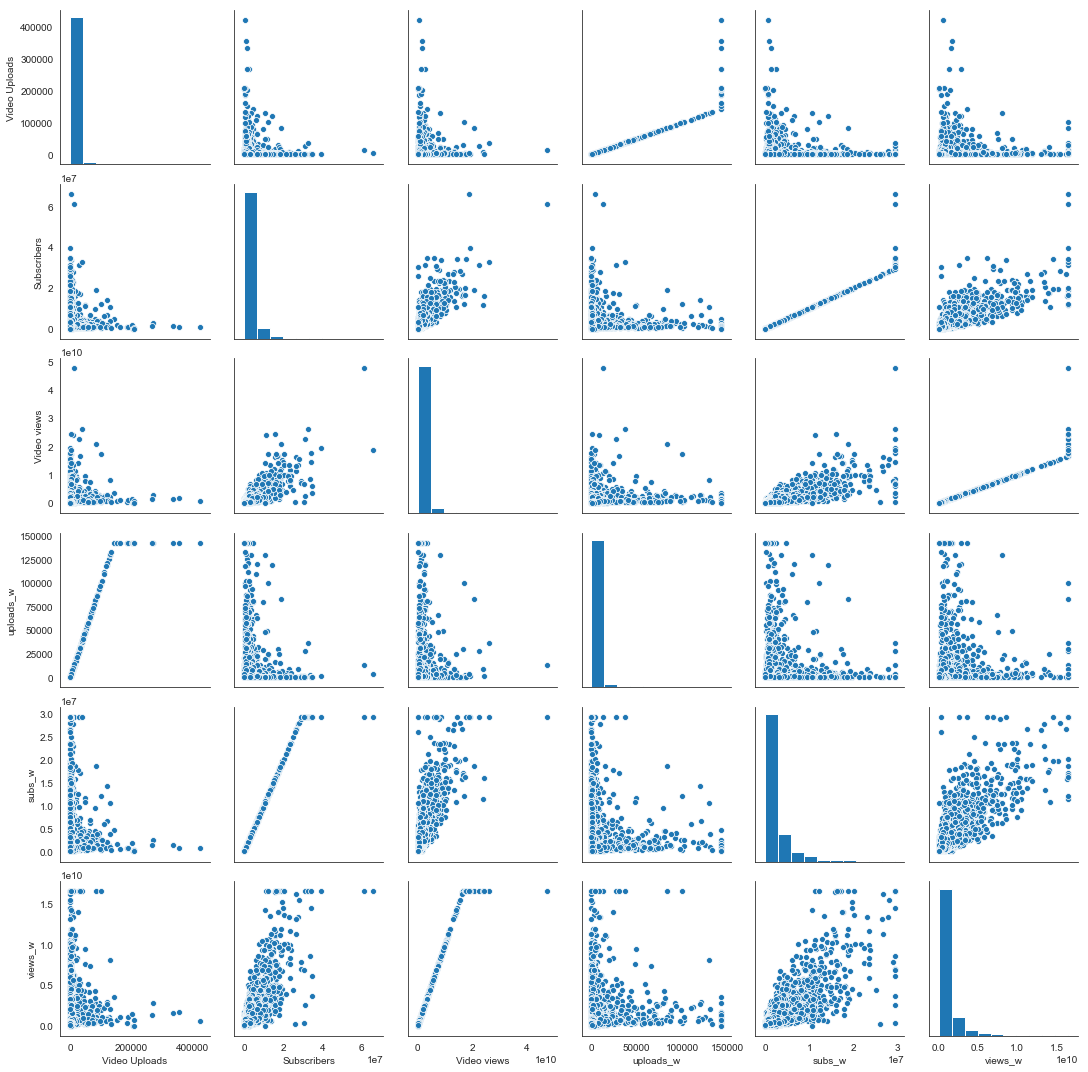

In [73]:
sns.pairplot(data)
plt.show()

In [74]:
# Views is our dependent variable

#Fit Our Model

regr = linear_model.LinearRegression()
Y = data['Video views']
X = data[['uploads_w', 'subs_w']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [14280.9020403    430.54834681]

Intercept: 
 -34066603.04832792

R-squared:
0.5993952169220289


This is not a fantastic $R^2$ value, so let's check our assumptions

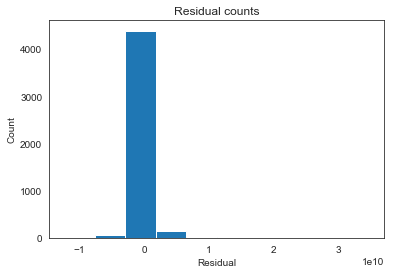

In [75]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['Video views']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

In [76]:
uploads = data['uploads_w']
subs = data['subs_w']

# Create a feature using a non-linear transformation.
data['sqrt_uploads'] = [math.sqrt(x) for x in  uploads]
data['sqrt_subs'] = [math.sqrt(x) for x in  subs]


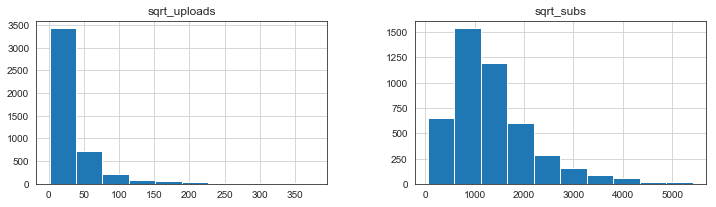

In [79]:
# Define the histogram plotting function
def plot_hists(dframe, fts):
    fig, axes = plt.subplots(1, len(fts), figsize=(12,3))
    for f in fts:
        idx = fts.index(f)
        dframe.hist(f, ax=axes[idx])

# Plot histograms for each variable
variables = ['sqrt_uploads', 'sqrt_subs']
plot_hists(data, variables)

In [81]:
regr = linear_model.LinearRegression()
Y = data['Video views']
X = data[['sqrt_uploads', 'sqrt_subs']]
regr.fit(X, Y)
sq
# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [4798546.30826717 1671133.6225398 ]

Intercept: 
 -1311587234.3733478

R-squared:
0.5163539745667967


The $R^2$ value is now worse. Great.

I'm not sure where to go from here with the regression, but let's do the KNN regression and hope it is maybe a tiny bit better.

In [85]:
data['vid_views'] = data['Video views']

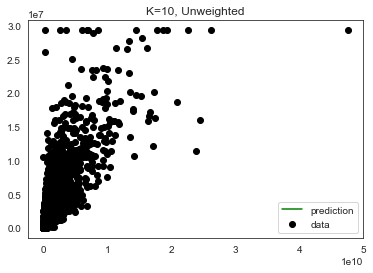

In [89]:
from sklearn import neighbors

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
X = pd.DataFrame(data.vid_views)
Y = data.subs_w
knn.fit(X, Y)

# Set up our prediction line.
T = np.arange(0, 50, 0.1)[:, np.newaxis]

# Trailing underscores are a common convention for a prediction.
Y_ = knn.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.title('K=10, Unweighted')
plt.show()

In [88]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Unweighted Accuracy: 0.52 (+/- 0.09)


# Second try: Video Uploads isn't very helpful (I had kind of hoped it would be), so we'll try to predict video views from the number of subscribers

In [90]:
data = data[['Subscribers','Video views']].apply(pd.to_numeric, errors='coerce').dropna()
X_train, y_train= data['Subscribers'], data['Video views']

In [91]:
# The data is too big, so instead of windsorizing let's try normalizing

def normalize(matrix):
    means = matrix.mean(axis=0)
    maxs = matrix.max(axis=0)
    mins = matrix.min(axis=0)
    return ((matrix - means) / (maxs - mins),means, maxs,mins)

def normalize_data(matrix, means, maxs, mins):
    return (matrix - means) / (maxs - mins)

In [92]:
matrix_train = np.column_stack((X_train,y_train))
matrix_train_norm, means, maxs, mins = normalize(matrix_train)
X_train = matrix_train_norm[:,0]
y_train = matrix_train_norm[:,1]

In [93]:
X_train.shape, y_train.shape 

((4610,), (4610,))